# Studying the influence of randomness in the data split and machine settings

By data split, the parameter random_state in `train_test_split()` could yield to suboptimal data split which could lead to suboptimal solution. 
In this small experiment, I have used a small dataset, to identify if setting the machine `seed` or `random_state` influences the model predictions. 

In [25]:
import pandas as pd 
import seaborn as sns 
import random 
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score

import xgboost as xgb
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [37]:
# helpers 

def get_metrics(X, y, state, model):
    if state is None:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=state)

    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc  = accuracy_score(y_test, preds)
    return acc

def plot_results(df, column_names=None, condition=None, figsize = (12,6)):

    if column_names is None:
        column_names = df.columns

    total_columns = len(column_names)
    plt.figure(figsize=figsize)        
    plt.suptitle(condition)
    for ix in range(1, total_columns+1):
        plt.subplot(total_columns, 1, ix)
        data_points = df[column_names[ix-1]]
        mu = data_points.mean()
        sig = data_points.std() 
        lower_bound = mu - 3*sig 
        upper_bound = mu + 3*sig
        sns.scatterplot(data_points)
        plt.axhline(y = lower_bound, color = 'r', linestyle = '--')
        plt.axhline(y = upper_bound, color = 'r', linestyle = '--')
        plt.fill_between([0, df.shape[0]], lower_bound, upper_bound, color='g', alpha=0.25, linestyle='--', linewidth=2)

def get_stats(dataframe, column_names=['logisticReg', 'RandomForest','DecisionTree', 'XGBoosting']):
    for col in column_names:
        lowest_value = round(dataframe[col].min()*100, 2) 
        highest_value = round(dataframe[col].max()*100, 2)
        pct_change = (highest_value - lowest_value) / lowest_value 
        print(f" for {col}: \n Accuracy is in range ({lowest_value}, {highest_value}) \n pct_change is {round(pct_change*100,2)}% \n {'--'*10}")

In [27]:
df = pd.read_csv('datasets/winequality-red.csv')
X = df.drop("quality", axis=1)
df['quality'] = df['quality'].apply(lambda x: 1 if x>5 else 0)
y = df['quality']
df.head() 

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


<Axes: xlabel='quality', ylabel='count'>

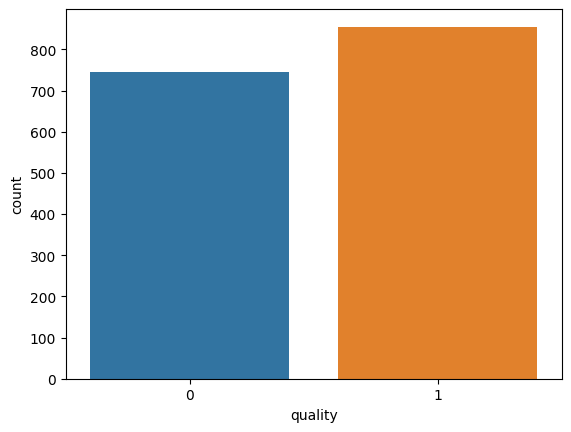

In [28]:
sns.countplot(data=df, x='quality')

Since the classes are imbalanced, we will create statified train test split
We will do 500 simulations to study the fluctuations in the prediction capabilities
    - since this is a multi-class classification, we will use Accuracy measure as our metric
    - we will set up 3 models Non_parametric, non-parametric ensemble and Parametric models 
        - randomForest : non-parametric ensemble
        - Logistic regression : parametric
        - DecisionTree : non-parametric


In [35]:
low = 1 
high = 1000 
num_seeds = 500
fig_size = (12,8)

# Vanilla Setting : without those paarameters 

In [30]:
results = [] 

for ix in tqdm(range(num_seeds)):

    # logistic 
    model = LogisticRegression(max_iter=100000) 
    acc_logistic = get_metrics(X, y, state=None, model=model)

    # Dtree 
    model = DecisionTreeClassifier()
    acc_dtree  = get_metrics(X, y, state=None, model=model)
    
    # RF 
    model = RandomForestClassifier() 
    acc_rf = get_metrics(X, y, state=None, model=model)

    # Boosting Model
    model = xgb.XGBClassifier()
    acc_xgboost = get_metrics(X, y, state=None, model=model)

    results.append([acc_logistic, acc_rf, acc_dtree, acc_xgboost])

100%|██████████| 500/500 [06:18<00:00,  1.32it/s]


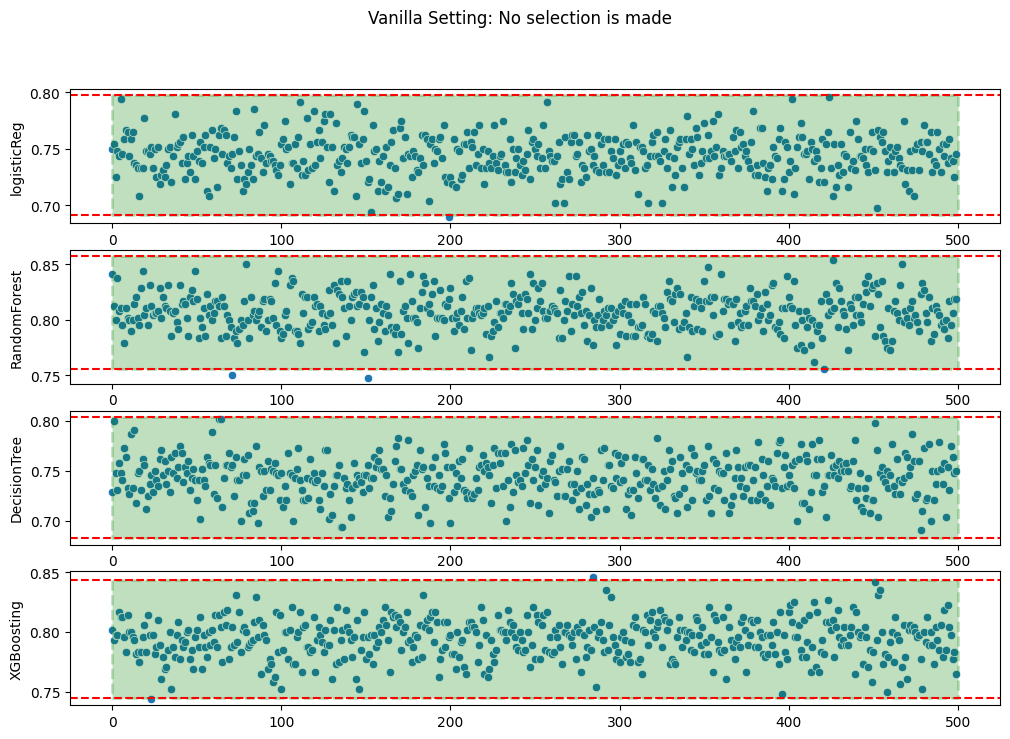

In [31]:
no_selection = pd.DataFrame(results, columns=['logisticReg', 'RandomForest','DecisionTree', 'XGBoosting'])
plot_results(
    df=no_selection, 
    column_names=['logisticReg', 'RandomForest','DecisionTree', 'XGBoosting'], 
    condition="Vanilla Setting: No selection is made", 
    figsize = fig_size
    )

In [46]:
get_stats(dataframe=no_selection)

 for logisticReg: 
 Accuracy is in range (68.96, 79.58) 
 pct_change is 15.4% 
 --------------------
 for RandomForest: 
 Accuracy is in range (74.79, 85.42) 
 pct_change is 14.21% 
 --------------------
 for DecisionTree: 
 Accuracy is in range (69.17, 80.21) 
 pct_change is 15.96% 
 --------------------
 for XGBoosting: 
 Accuracy is in range (74.38, 84.58) 
 pct_change is 13.71% 
 --------------------


# Fixed: state and Seed

100%|██████████| 500/500 [06:19<00:00,  1.32it/s]


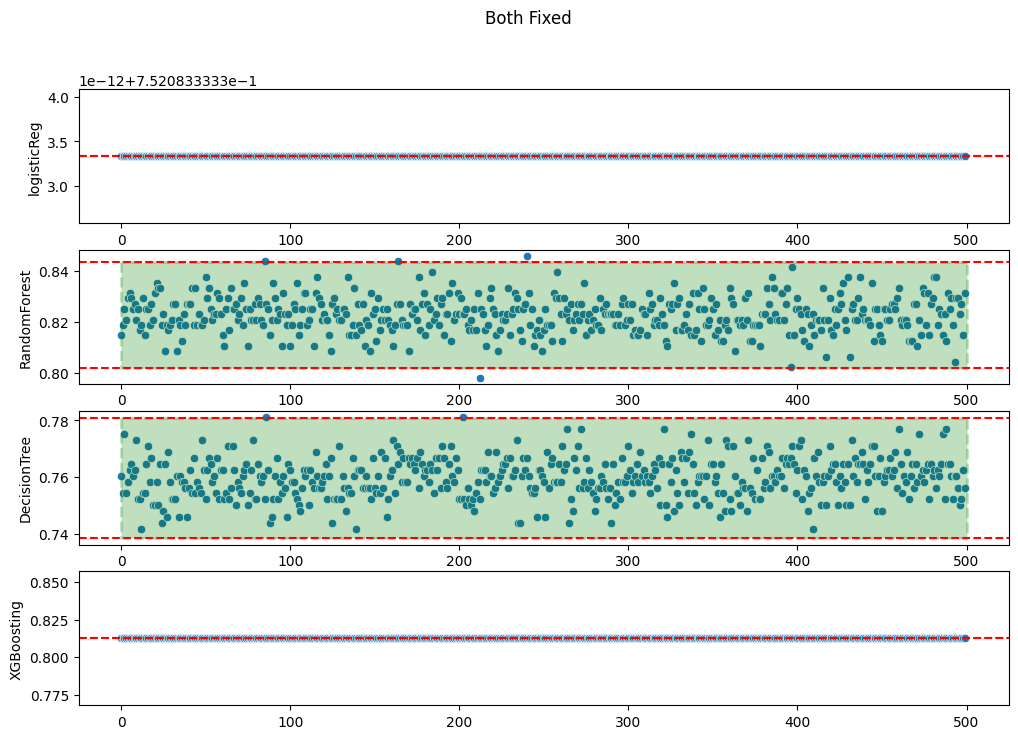

In [36]:
results = [] 

seed = random.randint(a=low, b=high**2)
state = random.randint(a=low, b=high**2)

for ix in tqdm(range(num_seeds)):
    random.seed(seed) 

    # logistic 
    model = LogisticRegression(max_iter=100000) 
    acc_logistic = get_metrics(X, y, state, model)

    # Dtree 
    model = DecisionTreeClassifier()
    acc_dtree  = get_metrics(X, y, state, model)
    
    # RF 
    model = RandomForestClassifier() 
    acc_rf = get_metrics(X, y, state, model)

    # Boosting Model
    model = xgb.XGBClassifier()
    acc_xgboost = get_metrics(X, y, state, model=model)

    results.append([seed, state, acc_logistic, acc_rf, acc_dtree, acc_xgboost])

both_fixed = pd.DataFrame(results, columns=['seed','state','logisticReg', 'RandomForest','DecisionTree', 'XGBoosting'])
plot_results(
    df=both_fixed, 
    column_names=['logisticReg', 'RandomForest','DecisionTree', 'XGBoosting'], 
    condition="Both Fixed", 
    figsize = fig_size
    )

In [38]:
get_stats(dataframe=both_fixed)

 for logisticReg: 
 Accuracy is in range (75.21, 75.21) 
 pct_change is 0.0% 
 --------------------
 for RandomForest: 
 Accuracy is in range (79.79, 84.58) 
 pct_change is 6.0% 
 --------------------
 for DecisionTree: 
 Accuracy is in range (74.17, 78.12) 
 pct_change is 5.33% 
 --------------------
 for XGBoosting: 
 Accuracy is in range (81.25, 81.25) 
 pct_change is 0.0% 
 --------------------


# seed fixed, state random 

100%|██████████| 500/500 [06:36<00:00,  1.26it/s]


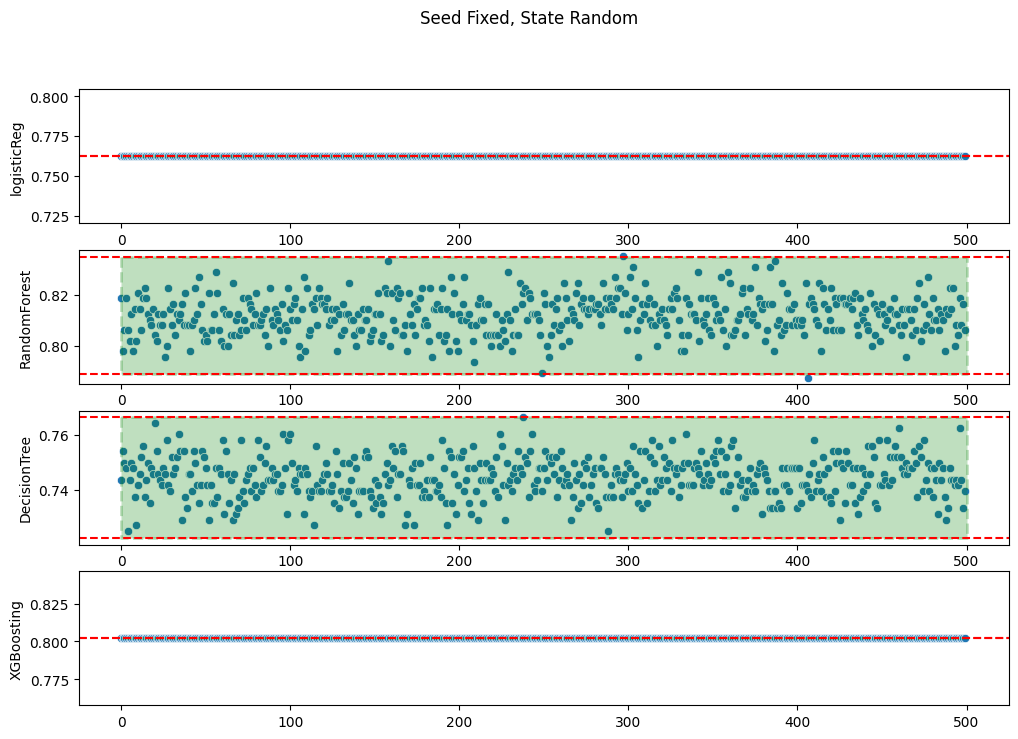

In [39]:
results = [] 

seed = random.randint(a=low, b=high**2)

for ix in tqdm(range(num_seeds)):
    random.seed(seed) 
    state = random.randint(a=low, b=high**2)
    
    # logistic 
    model = LogisticRegression(max_iter=100000) 
    acc_logistic = get_metrics(X, y, state, model)

    # Dtree 
    model = DecisionTreeClassifier()
    acc_dtree  = get_metrics(X, y, state, model)
    
    # RF 
    model = RandomForestClassifier() 
    acc_rf = get_metrics(X, y, state, model)

    # Boosting Model
    model = xgb.XGBClassifier()
    acc_xgboost = get_metrics(X, y, state, model=model)

    results.append([seed, state, acc_logistic, acc_rf, acc_dtree, acc_xgboost])

seed_fixed_state_random = pd.DataFrame(results, columns=['seed','state','logisticReg', 'RandomForest','DecisionTree', 'XGBoosting'])
plot_results(
    df=seed_fixed_state_random, 
    column_names=['logisticReg', 'RandomForest','DecisionTree', 'XGBoosting'], 
    condition="Seed Fixed, State Random", 
    figsize = fig_size
    )

In [40]:
get_stats(dataframe=seed_fixed_state_random)

 for logisticReg: 
 Accuracy is in range (76.25, 76.25) 
 pct_change is 0.0% 
 --------------------
 for RandomForest: 
 Accuracy is in range (78.75, 83.54) 
 pct_change is 6.08% 
 --------------------
 for DecisionTree: 
 Accuracy is in range (72.5, 76.67) 
 pct_change is 5.75% 
 --------------------
 for XGBoosting: 
 Accuracy is in range (80.21, 80.21) 
 pct_change is 0.0% 
 --------------------


# Seed Random, state fixed

100%|██████████| 500/500 [06:28<00:00,  1.29it/s]


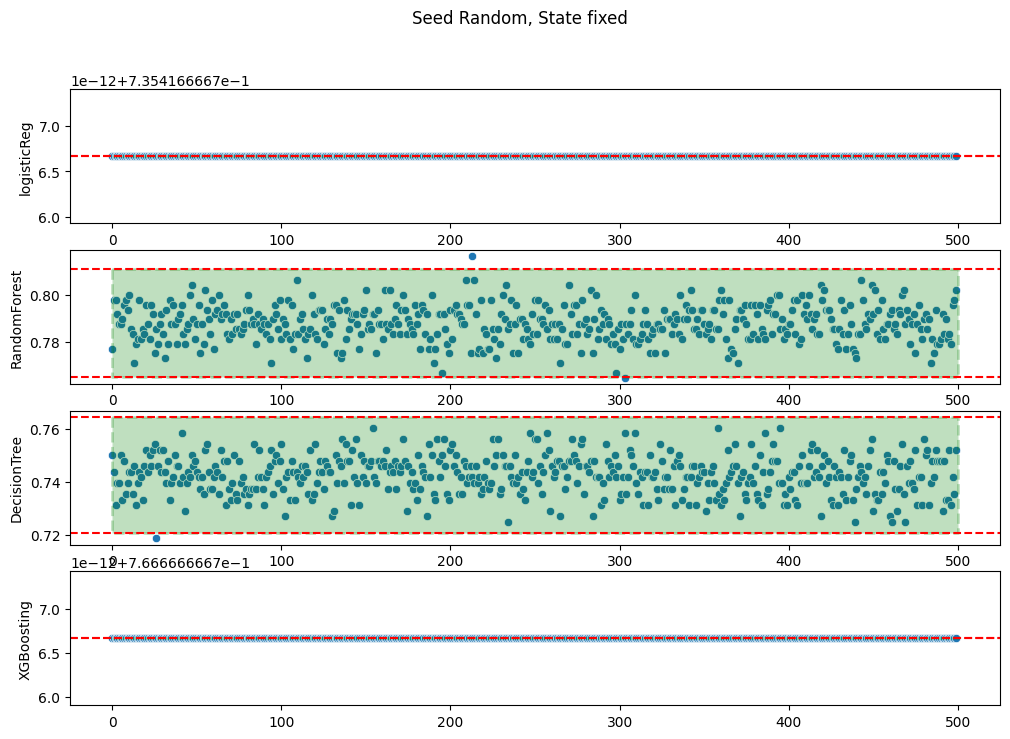

In [41]:
results = [] 

state = random.randint(a=low, b=high**2)

for ix in tqdm(range(num_seeds)):
    seed = random.randint(a=low, b=high**2)
    random.seed(seed) 
    
    # logistic 
    model = LogisticRegression(max_iter=100000) 
    acc_logistic = get_metrics(X, y, state, model)

    # Dtree 
    model = DecisionTreeClassifier()
    acc_dtree  = get_metrics(X, y, state, model)
    
    # RF 
    model = RandomForestClassifier() 
    acc_rf = get_metrics(X, y, state, model)

    # Boosting Model
    model = xgb.XGBClassifier()
    acc_xgboost = get_metrics(X, y, state, model=model)

    results.append([seed, state, acc_logistic, acc_rf, acc_dtree, acc_xgboost])

seed_random_state_fixed = pd.DataFrame(results, columns=['seed','state','logisticReg', 'RandomForest','DecisionTree', 'XGBoosting'])
plot_results(
    df=seed_random_state_fixed, 
    column_names=['logisticReg', 'RandomForest','DecisionTree', 'XGBoosting'], 
    condition="Seed Random, State fixed", 
    figsize = fig_size
    )

In [42]:
get_stats(dataframe=seed_random_state_fixed)

 for logisticReg: 
 Accuracy is in range (73.54, 73.54) 
 pct_change is 0.0% 
 --------------------
 for RandomForest: 
 Accuracy is in range (76.46, 81.67) 
 pct_change is 6.81% 
 --------------------
 for DecisionTree: 
 Accuracy is in range (71.88, 76.04) 
 pct_change is 5.79% 
 --------------------
 for XGBoosting: 
 Accuracy is in range (76.67, 76.67) 
 pct_change is 0.0% 
 --------------------


# both random

In [43]:
results = []

for ix in tqdm(range(num_seeds)):
    state = random.randint(a=low, b=high**2)
    seed = random.randint(a=low, b=high**2)
    
    random.seed(seed) 
    
    # logistic 
    model = LogisticRegression(max_iter=100000) 
    acc_logistic = get_metrics(X, y, state, model)

    # Dtree 
    model = DecisionTreeClassifier()
    acc_dtree  = get_metrics(X, y, state, model)
    
    # RF 
    model = RandomForestClassifier() 
    acc_rf = get_metrics(X, y, state, model)

    # Boosting Model
    model = xgb.XGBClassifier()
    acc_xgboost = get_metrics(X, y, state, model=model)

    results.append([seed, state, acc_logistic, acc_rf, acc_dtree, acc_xgboost])

100%|██████████| 500/500 [06:14<00:00,  1.33it/s]


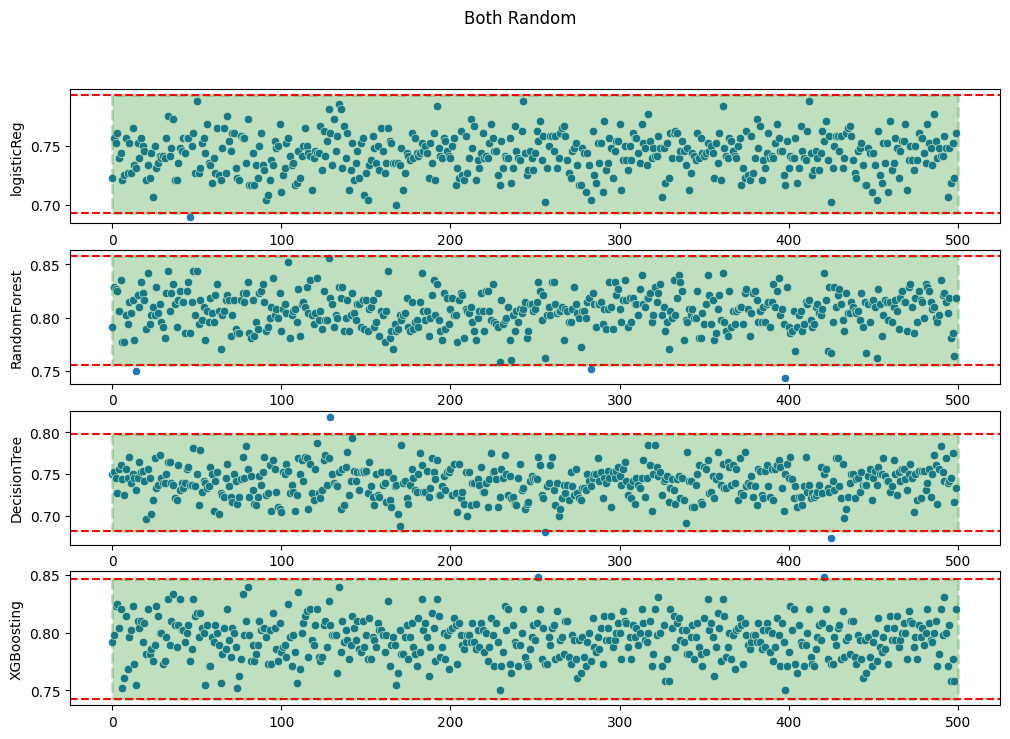

In [44]:
both_random = pd.DataFrame(results, columns=['seed','state','logisticReg', 'RandomForest','DecisionTree', 'XGBoosting'])
plot_results(
    df=both_random, 
    column_names=['logisticReg', 'RandomForest','DecisionTree', 'XGBoosting'], 
    condition="Both Random", 
    figsize = fig_size
    )

In [45]:
get_stats(dataframe=both_random)

 for logisticReg: 
 Accuracy is in range (68.96, 78.75) 
 pct_change is 14.2% 
 --------------------
 for RandomForest: 
 Accuracy is in range (74.38, 85.62) 
 pct_change is 15.11% 
 --------------------
 for DecisionTree: 
 Accuracy is in range (67.29, 81.88) 
 pct_change is 21.68% 
 --------------------
 for XGBoosting: 
 Accuracy is in range (75.0, 84.79) 
 pct_change is 13.05% 
 --------------------
